In [1]:
from pandas_datareader import DataReader
from datetime import datetime
from pandas import DataFrame, Series
import pandas as pd; import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
from matplotlib.dates import MonthLocator,MONTHLY
import datetime as dt
import pylab

/Users/mniu/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
AAPL = DataReader('AAPL',  'yahoo', datetime(2017, 3, 1), datetime(2017, 10, 1))
AAPL.index.name = 'DateTime'
AAPL.drop('Close', axis=1, inplace = True)
AAPL.columns = ['Open', 'High', 'Low', 'Close', 'Volume']



In [3]:
# drop the date index from the dateframe & make a copy
daysreshape = AAPL.reset_index()
# convert the datetime64 column in the dataframe to 'float days'
daysreshape['DateTime']=mdates.date2num(daysreshape['DateTime'].astype(dt.date))
# clean day data for candle view 
daysreshape.drop('Volume', axis=1, inplace = True)
daysreshape = daysreshape.reindex(columns=['DateTime','Open','High','Low','Close'])


In [4]:
stock_b_code = 'AAPL'
MA1 = 10
MA2 = 50
startdate = dt.date(2017, 3, 1)
enddate = dt.date(2017, 10, 1)


In [5]:
def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

def computeMACD(x, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow

def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

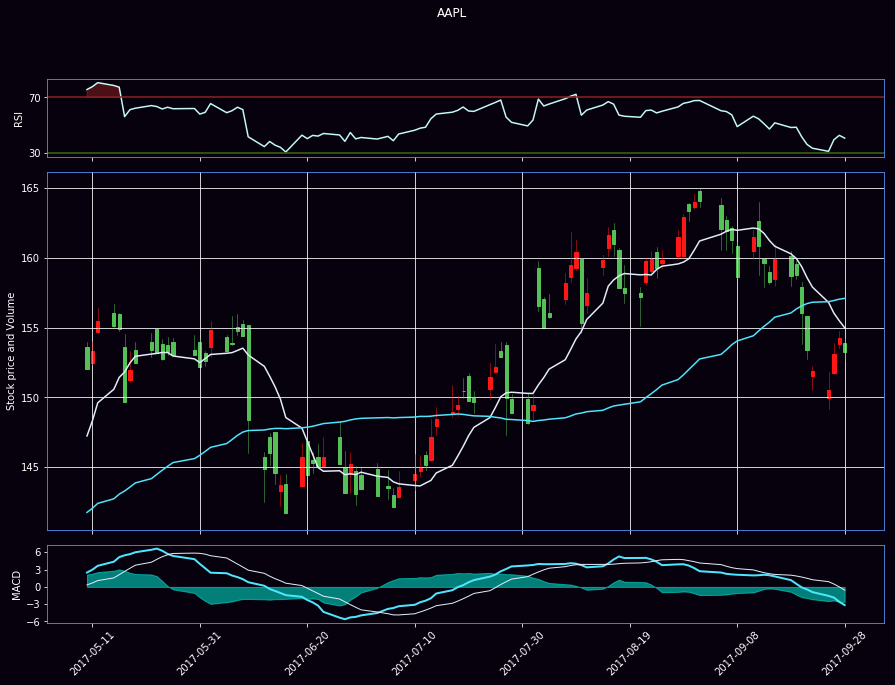

In [8]:

Av1 = daysreshape['Close'].rolling(window=MA1).mean()
Av2 = daysreshape['Close'].rolling(window=MA2).mean()
SP = len(daysreshape.DateTime.values[MA2-1:])
fig = plt.figure(facecolor='#07000d',figsize=(15,10))

ax1 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4, axisbg='#07000d')
candlestick_ohlc(ax1, daysreshape.values[-SP:], width=.6, colorup='#ff1717', colordown='#53c156')
Label1 = str(MA1)+' SMA'
Label2 = str(MA2)+' SMA'

ax1.plot(daysreshape.DateTime.values[-SP:],Av1[-SP:],'#e1edf9',label=Label1, linewidth=1.5)
ax1.plot(daysreshape.DateTime.values[-SP:],Av2[-SP:],'#4ee6fd',label=Label2, linewidth=1.5)
ax1.grid(True, color='w')

volumeMin = 0
# ax1v = ax1.twinx()
# ax1v.fill_between(daysreshape.DateTime.values[-SP:],volumeMin, AAPL.Volume.values[-SP:], facecolor='#00ffe8', alpha=.4)
# ax1v.axes.yaxis.set_ticklabels([])
# ax1v.grid(False)
# ###Edit this to 3, so it's a bit larger
# ax1v.set_ylim(0, 3*AAPL.Volume.values.max())
# ax1v.spines['bottom'].set_color("#5998ff")
# ax1v.spines['top'].set_color("#5998ff")
# ax1v.spines['left'].set_color("#5998ff")
# ax1v.spines['right'].set_color("#5998ff")
# ax1v.tick_params(axis='x', colors='w')
# ax1v.tick_params(axis='y', colors='w')

ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.yaxis.label.set_color("w")
ax1.spines['bottom'].set_color("#5998ff")
ax1.spines['top'].set_color("#5998ff")
ax1.spines['left'].set_color("#5998ff")
ax1.spines['right'].set_color("#5998ff")
ax1.tick_params(axis='y', colors='w')
ax1.tick_params(axis='x', colors='w')
plt.ylabel('Stock price and Volume').set_color('w')


ax0 = plt.subplot2grid((6,4), (0,0), sharex=ax1, rowspan=1, colspan=4, axisbg='#07000d')
rsi = rsiFunc(daysreshape.Close.values)
rsiCol = '#c1f9f7'
posCol = '#386d13'
negCol = '#8f2020'

ax0.plot(daysreshape.DateTime.values[-SP:], rsi[-SP:], rsiCol, linewidth=1.5)
ax0.axhline(70, color=negCol)
ax0.axhline(30, color=posCol)
ax0.fill_between(daysreshape.DateTime.values[-SP:], rsi[-SP:], 70, where=(rsi[-SP:]>=70), facecolor=negCol, edgecolor=negCol, alpha=0.5)
ax0.fill_between(daysreshape.DateTime.values[-SP:], rsi[-SP:], 30, where=(rsi[-SP:]<=30), facecolor=posCol, edgecolor=posCol, alpha=0.5)
ax0.set_yticks([30,70])
ax0.yaxis.label.set_color("w")
ax0.spines['bottom'].set_color("#5998ff")
ax0.spines['top'].set_color("#5998ff")
ax0.spines['left'].set_color("#5998ff")
ax0.spines['right'].set_color("#5998ff")
ax0.tick_params(axis='y', colors='w')
ax0.tick_params(axis='x', colors='w')
plt.ylabel('RSI')

# plot an MACD indicator on bottom
ax2 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4, axisbg='#07000d')
fillcolor = '#00ffe8'
nslow = 26
nfast = 12
nema = 9
emaslow, emafast, macd = computeMACD(daysreshape.Close.values)
ema9 = ExpMovingAverage(macd, nema)
ax2.plot(daysreshape.DateTime.values[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
ax2.plot(daysreshape.DateTime.values[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
ax2.fill_between(daysreshape.DateTime.values[-SP:], macd[-SP:]-ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
ax2.spines['bottom'].set_color("#5998ff")
ax2.spines['top'].set_color("#5998ff")
ax2.spines['left'].set_color("#5998ff")
ax2.spines['right'].set_color("#5998ff")
ax2.tick_params(axis='x', colors='w')
ax2.tick_params(axis='y', colors='w')
plt.ylabel('MACD', color='w')
ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
for label in ax2.xaxis.get_ticklabels():
    label.set_rotation(45)  
plt.suptitle(stock_b_code,color='w')
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
     
plt.show()

In [ ]:
# 